The goal here is to grab the PTF lightcurves for standard stars and quasars in Stripe 82 that I used in CRTS.

In [1]:
import numpy as np
import os
import pandas as pd 
from astropy.table import Table

import sys
sys.path.insert(0, '/Users/chris/GradResearch/CRTS_PROJECT/code/')

import CRTS_paper_modules as mod 

Search source catalog on  PTF objects table and 
--> use ngoodobs > 10 

### Read in the QSO in S82

Read in the CRTS-SDSS cross-matched table :

In [11]:
# This grabs the colnames , and the catalog as a dict from the 
# database file 
colnames, catalog  = mod.get_qso_catalog()
catalog.keys()

Zipping CRTS-SDSS quasars catalog from ../data_products/CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt
Read in 7601 quasars from CRTS


dict_keys(['i', 'ra_CRTS', 'm_ang_deg', 'dec_SDSS', 'u', 'ra_SDSS', 'dec_CRTS', 'g', 'mjd_span', 'r', 'N_rows', 'z', 'CRTS_avg_m', 'CRTS_avg_e', 'CRTS_id', 'mjd_uniq_N', 'redshift'])

### Read in the stars in S82

In [12]:
colnames, catalog_stars  = mod.get_stars_catalog()
catalog_stars.keys()

zipping CRTS-SDSS stars catalog...
Read in catalog for 48250 stars from CRTS 


dict_keys(['crts_id', 'g_Nobs', 'mjd_N', 'dec_SDSS', 'ra_SDSS', 'dec_CRTS', 'mjd_span', 'CRTS_Merr', 'ra_CRTS', 'CRTS_M', 'r_mMed', 'g_mMed', 'm_ang_deg', 'i_mMed', 'N_rows'])

### PTF Objects : make IPAC format S82 stars list 

In [19]:
# Here astropy ascii does not directly have an import from a dict, but we can import from a dataframe
# thus we make  dict --> dataframe --> table  conversion 

# convert the dictionary to  a pandas dataframe
df_stars = pd.DataFrame.from_dict(catalog_stars)

# convert the dataframe to an astropy Table 
tab_stars = Table.from_pandas(df_stars)

# initiate a Table to save the relevant cols 
save_stars = Table()
save_stars['ra'] = tab_stars['ra_SDSS']  # use SDSS ra, dec because it's more accurate than the CRTS 
save_stars['dec'] = tab_stars['dec_SDSS']
save_stars['major'] =  0.1 # that's a search radius  : a semimajor axis  for an ellipse with 0 eccentricity... 
save_stars.write('IRSA_stars_s82_ra_dec.tbl', format='ipac') # use that to query against PTF Objects 

### PTF Objects : make IPAC format S82 QSO list

To check which objects have been detected by iPTF, we will be querying against the PTF Objects catalog. To do that we upload a list of  RA and dec for the 7601 spectroscopically-confirmed quasars in S82, to positionally look for those sources in iPTF.

In [20]:
# Here astropy ascii does not directly have an import from a dict, but we can import from a dataframe
# thus we make  dict --> dataframe --> table  conversion 

# convert the dictionary to  a pandas dataframe
df = pd.DataFrame.from_dict(catalog)

# convert the dataframe to an astropy Table 
tab = Table.from_pandas(df)

# initiate a Table to save the relevant cols 
save = Table()
save['ra'] = tab['ra_SDSS']  # use SDSS ra, dec because it's more accurate than the CRTS 
save['dec'] = tab['dec_SDSS']
save['major'] =  0.1 # that's a search radius  : a semimajor axis  for an ellipse with 0 eccentricity... 
save.write('IRSA_QSO_s82_ra_dec.tbl', format='ipac') # use that to query against PTF Objects 

## Querying IRSA : NASA/IPAC Infrared Science Archive  


From the main page https://irsa.ipac.caltech.edu/frontpage/ <img src="figures/1_main_page.png">

We select "catalogs", and then choose the 'PTF' catalog : <img src="figures/2_catalog_choice.png" style="width: 500px;">

We then select  'PTF Objects catalog'  : <img src="figures/3_subcatalog.png" style="width: 500px;">

And run the Multi-Object Search, setting the search radius to 2 arcsec  : <img src="figures/4_query.png" style="width: 500px;">

and ngoodobs > 10:  <img src="figures/5_ngoodobs.png" style="width: 1000px;">

I don't need all columns : grab  ra,dec,oid,fid,  ngoodobs, nbestobs, bestmaxmag, ra, dec, obsmjd, mag_autocorr,  magerr_auto   
press 'Run Query' on the very bottom of the page  <img src="figures/6_run_the_query.png" style="width: 500px;">

Result :  6606 sources  with ngoodobs > 10 . In the result IPAC Table, I can select all rows in the upper left corner (each row corresponds to one object and contains various summary info about the aggregate quality of each lightcurve), and then save in ../IPAC_tables/

In [2]:
# check which version I'm dealing with...
#import astropy
#astropy.version.version

'1.3'

In [25]:
# Read in the qso output table 
qso_table = Table.read('../IPAC_tables/IpacTableFromSource_QSO_S82.tbl', format='ipac')

In [57]:
# Read in the stars output table 
stars_table = Table.read('../IPAC_tables/IpacTableFromSource_stars_S82.tbl', format='ipac')

### note : ngoodobs vs nbestobs



the code below gives some idea how 'good' differs from 'best'... 

uint32_t bad_photo = SATELLITE | HIGH_DARK | NON_LINEAR | HOT_PIXEL | SATURATED_PIXEL | DEAD_PIXEL | NAN_PIXEL;
#uint32_t bad_photo_strict = SATELLITE | HIGH_DARK | NON_LINEAR | HOT_PIXEL | GHOST_PIXEL | SATURATED_PIXEL | DEAD_PIXEL | NAN_PIXEL | HALO;

nmag_ok = “ngoodobs” =  if( ((ipacflag & bad_photo) == 0) & ((sexflag & 506) == 0) )
nmag_ok_strict = “nbestobs” =  if( ((ipacflag & bad_photo_strict) == 0) & ((sexflag & 507) == 0) )

Thus unlike good designation,  best includes HALO,  which is a keyword for being close to a bright star (how close - email Eric B.  )

Also note iPTF flags that have a good SExtractor documentation:

 * sexflag 506
 * sexflag 507 

### Select good PTF quasars in S82...

In [56]:
#qso_table.colnames

# NOTE : since it was matched on ra, dec,  it also stores ra_01,  dec_01, which
# represent the PTF values that were matched to SDSS-based  ra, dec 

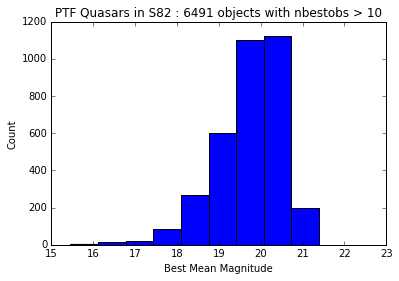

In [42]:
# choose of those that are available only those with more than 
# 10 epochs ...
require_nbestobs_gt = 10 
select_by_nobs = qso_table['nbestobs'] > require_nbestobs_gt

#  in case we want to add some more masks above., we can combine them here 
select_mask = select_by_nobs

%matplotlib inline
import matplotlib.pyplot as plt 

plt.hist(qso_table['bestmeanmag'][select_mask])
plt.title('PTF Quasars in S82 : %d objects with nbestobs > %d'%(np.sum(select_mask), require_nbestobs_gt))
plt.ylabel('Count')
plt.xlabel('Best Mean Magnitude')

In [45]:
# Save those PTF Quasars that we like to a table that we will use to query for lightcurves...
selected = qso_table[['ra','dec']][select_by_nobs]

# save those sources that we are now going to query PTF lightcurve database against in the ipac format ... 
selected.write('IPAC_get_lightcurves_QSO_ra_dec.tbl', format='ipac')

In [105]:
# Test : select only a few to quickly see if we are retrieving all rows that there should be ... 

selected[:10].write('../IPAC_query_tables/IPAC_get_lightcurves_test_10_QSO_ra_dec.tbl', format='ipac')

### Select good PTF stars in S82 

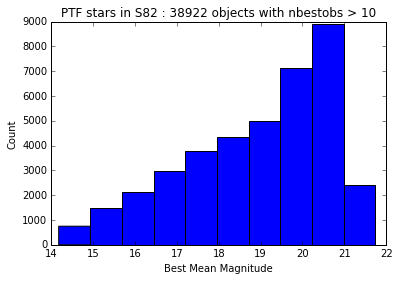

In [60]:
# choose of those that are available only those with more than 
# 10 epochs ...
require_nbestobs_gt = 10 
select_by_nobs = stars_table['nbestobs'] > require_nbestobs_gt

# remove those with spurioursly low magnitude... 
select_by_meanmag  = stars_table['bestmeanmag'] > 10 

# combine masks 
select_mask = select_by_nobs * select_by_meanmag
%matplotlib inline
import matplotlib.pyplot as plt 

plt.hist(stars_table['bestmeanmag'][select_mask])
plt.title('PTF stars in S82 : %d objects with nbestobs > %d'%(np.sum(select_mask), require_nbestobs_gt))
plt.ylabel('Count')
plt.xlabel('Best Mean Magnitude')

In [61]:
# Save those PTF stars that we like to a table that we will use to query for lightcurves...
selected_stars = stars_table[['ra','dec']][select_mask]

# save those sources that we are now going to query PTF lightcurve database against in the ipac format ... 
selected_stars.write('IPAC_get_lightcurves_stars_ra_dec.tbl', format='ipac')

### Grab lightcurves...

Now we use that file to query against the PTF Lightcurve Database <img src="figures/7_grab_lightcurves.png" style="width: 500px;">

Read in the query results... 

In [62]:
# all lightcurves (may take a minute to read as the file has size of 82 MB ... )
lcs_qso = Table.read('../IPAC_tables/Ipac_PTF_lightcurves_QSO_S82.tbl', format='ipac')



In [65]:
#lcs_qso.keys()

Note : there may have been sources that are on CCD edges, so that they were detected on  two CCDs  For those sources, the ra_01 and dec_01 may be slightly different on the two chips because of dithering, but not more than 1.5 arcsec (at least according to David Schupe : schupe@ipac.caltech.edu)

Thus to gather all rows corresponding to a single source, we group by ra, dec (the input SDSS ra, dec, rather than the PTF ra_01, dec_01):

In [122]:
len(np.unique(lcs_qso['oid']))



6472

In [88]:
len(np.unique(lcs_qso['dec']))

6461

In [121]:
# how many sources we have 
len(np.unique(lcs_qso['ra']))



6471

In [118]:
len(np.unique(lcs_qso['ra_01']))

6480

In [108]:
# test case... querying for 10 objects ...
lcs_test = Table.read('../IPAC_output_tables/Ipac_PTF_lightcurves_test_QSO.tbl', format='ipac')



In [114]:
lcs_test

cntr_01,dist_x,pang_x,ra_01,dec_01,obsmjd,mag_autocorr,magerr_auto,oid,ra,dec,fid,transient_flag,astrometricrms,nobs,ngoodobs,nbestobs,referencemag,referencemagerr,medianmag,bestmedianmag,meanmag,bestmeanmag,magrms,bestmagrms,sid,s_ra,s_dec,ptffield,ccdid,hmjd,nid,mag_auto,limitmag,absphotzp,fwhmsex,fwhm_image,qaflags,flags,photcalflag,goodflag
,arcsec,deg,degrees,degrees,days,mag,mag,,degrees,degrees,,,degrees,,,,mag,mag,mag,mag,mag,mag,mag,mag,,degrees,degrees,,,days,,mag,mag,mag,arcsec,pixels,,,"0=No, 1=Yes","0=No, 1=Yes"
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1,0.0,0.0,6.968328,0.437734,56903.3404372,18.747,0.04,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21305664001544,6.968329,0.437729,2699,6,56903.3455472,1968,18.76,21.93,27.896,2.45,2.713,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56924.3337972,18.774,0.041,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21507653001359,6.968328,0.43773,2699,6,56924.3395172,1987,18.778,21.754,27.874,2.45,2.531,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56904.3353572,18.766,0.047,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21299870001227,6.968337,0.43772,2699,6,56904.3405072,1969,18.784,21.467,27.896,2.45,2.968,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56904.3635872,18.721,0.043,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21299891001474,6.96832,0.437738,2699,6,56904.3687372,1969,18.728,21.97,27.901,2.45,2.778,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56931.3226572,18.803,0.044,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,22270304001348,6.968356,0.437729,2699,6,56931.3284272,1994,18.802,21.732,27.858,2.45,2.63,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56931.3685672,18.799,0.044,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,22270414001278,6.968343,0.437742,2699,6,56931.3743372,1994,18.798,21.666,27.849,2.55,2.937,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56925.3380872,18.753,0.041,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21522485001368,6.96833,0.437735,2699,6,56925.3438272,1988,18.75,21.685,27.852,2.55,2.645,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56925.3921172,18.694,0.042,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21522530001285,6.968333,0.437735,2699,6,56925.3978572,1988,18.691,21.604,27.839,2.65,2.935,0,131072,0,1


In [115]:
# grab the first object by ra 
test_obj_rows = lcs_test['ra'] == np.unique(lcs_test['ra'])[0]
# count how many rows
len(lcs_test[test_obj_rows])

60

In [117]:
# display the first few rows
lcs_test[test_obj_rows][:6]


cntr_01,dist_x,pang_x,ra_01,dec_01,obsmjd,mag_autocorr,magerr_auto,oid,ra,dec,fid,transient_flag,astrometricrms,nobs,ngoodobs,nbestobs,referencemag,referencemagerr,medianmag,bestmedianmag,meanmag,bestmeanmag,magrms,bestmagrms,sid,s_ra,s_dec,ptffield,ccdid,hmjd,nid,mag_auto,limitmag,absphotzp,fwhmsex,fwhm_image,qaflags,flags,photcalflag,goodflag
,arcsec,deg,degrees,degrees,days,mag,mag,,degrees,degrees,,,degrees,,,,mag,mag,mag,mag,mag,mag,mag,mag,,degrees,degrees,,,days,,mag,mag,mag,arcsec,pixels,,,"0=No, 1=Yes","0=No, 1=Yes"
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1,0.0,0.0,6.968328,0.437734,56903.3404372,18.747,0.04,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21305664001544,6.968329,0.437729,2699,6,56903.3455472,1968,18.76,21.93,27.896,2.45,2.713,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56924.3337972,18.774,0.041,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21507653001359,6.968328,0.43773,2699,6,56924.3395172,1987,18.778,21.754,27.874,2.45,2.531,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56904.3353572,18.766,0.047,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21299870001227,6.968337,0.43772,2699,6,56904.3405072,1969,18.784,21.467,27.896,2.45,2.968,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56904.3635872,18.721,0.043,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,21299891001474,6.96832,0.437738,2699,6,56904.3687372,1969,18.728,21.97,27.901,2.45,2.778,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56931.3226572,18.803,0.044,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,22270304001348,6.968356,0.437729,2699,6,56931.3284272,1994,18.802,21.732,27.858,2.45,2.63,0,131072,0,1
1,0.0,0.0,6.968328,0.437734,56931.3685672,18.799,0.044,26991060002225,6.968328,0.437734,1,0,4.777896e-07,125,125,123,18.717,0.006,18.746,18.748,18.743,18.743,0.06,0.06,22270414001278,6.968343,0.437742,2699,6,56931.3743372,1994,18.798,21.666,27.849,2.55,2.937,0,131072,0,1


### Example qso lightcurve ... 

In [97]:
# grab the first object by oid 
test_obj_rows = lcs_qso['oid'] == np.unique(lcs_qso['oid'])[0]
# display first few rows... 
lcs_qso[test_obj_rows][:6]

cntr_01,dist_x,pang_x,ra_01,dec_01,obsmjd,mag_autocorr,magerr_auto,oid,ra,dec,fid,transient_flag,astrometricrms,nobs,ngoodobs,nbestobs,referencemag,referencemagerr,medianmag,bestmedianmag,meanmag,bestmeanmag,magrms,bestmagrms,sid,s_ra,s_dec,ptffield,ccdid,hmjd,nid,mag_auto,limitmag,absphotzp,fwhmsex,fwhm_image,qaflags,flags,photcalflag,goodflag
,arcsec,deg,degrees,degrees,days,mag,mag,,degrees,degrees,,,degrees,,,,mag,mag,mag,mag,mag,mag,mag,mag,,degrees,degrees,,,days,,mag,mag,mag,arcsec,pixels,,,"0=No, 1=Yes","0=No, 1=Yes"
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
2402,0.0,0.0,1.50903,-0.899447,56905.2801772,19.407,0.094,25921020000816,1.50903,-0.899447,1,0,8.881669e-07,204,189,174,19.686,0.015,19.64,19.632,19.656,19.652,0.136,0.127,21294506001222,1.509024,-0.899403,2592,2,56905.2856372,1970,19.406,20.78,27.757,2.35,3.429,0,131072,0,1
2402,0.0,0.0,1.50903,-0.899447,56942.3708872,19.959,0.124,25921020000816,1.50903,-0.899447,1,0,8.881669e-07,204,189,174,19.686,0.015,19.64,19.632,19.656,19.652,0.136,0.127,21770129000931,1.509045,-0.8994,2592,2,56942.3763972,2006,19.958,20.576,27.683,2.45,3.332,0,131072,0,1
2402,0.0,0.0,1.50903,-0.899447,56904.3177872,19.612,0.08,25921020000816,1.50903,-0.899447,1,0,8.881669e-07,204,189,174,19.686,0.015,19.64,19.632,19.656,19.652,0.136,0.127,21301786001582,1.509043,-0.89943,2592,2,56904.3232272,1969,19.616,21.253,27.794,2.25,2.442,0,131072,0,1
2402,0.0,0.0,1.50903,-0.899447,56903.3218972,19.567,0.057,25921020000816,1.50903,-0.899447,1,0,8.881669e-07,204,189,174,19.686,0.015,19.64,19.632,19.656,19.652,0.136,0.127,21304471002246,1.509005,-0.899428,2592,2,56903.3273072,1968,19.577,21.851,27.799,2.25,2.775,0,131072,0,1
2402,0.0,0.0,1.50903,-0.899447,56903.3515872,19.557,0.056,25921020000816,1.50903,-0.899447,1,0,8.881669e-07,204,189,174,19.686,0.015,19.64,19.632,19.656,19.652,0.136,0.127,21304490002307,1.509005,-0.899456,2592,2,56903.3569872,1968,19.567,21.946,27.811,2.15,2.641,0,131072,0,1
2402,0.0,0.0,1.50903,-0.899447,56915.2918972,19.589,0.076,25921020000816,1.50903,-0.899447,1,0,8.881669e-07,204,189,174,19.686,0.015,19.64,19.632,19.656,19.652,0.136,0.127,21345421001547,1.508995,-0.899431,2592,2,56915.2975972,1978,19.6,21.22,27.726,2.35,2.977,0,131072,0,1


Again : there are 64 rows :  len(lcs_qso[test_obj_rows]) , even though nbestobs = 174... Why ?  

In [95]:
    # grab the first object  by ra 
test_obj_ra = np.unique(lcs_qso['ra'])[0]
test_obj_rows = lcs_qso['ra'] == test_obj_ra
# display first few rows... 

lcs_qso[test_obj_rows][:6]

cntr_01,dist_x,pang_x,ra_01,dec_01,obsmjd,mag_autocorr,magerr_auto,oid,ra,dec,fid,transient_flag,astrometricrms,nobs,ngoodobs,nbestobs,referencemag,referencemagerr,medianmag,bestmedianmag,meanmag,bestmeanmag,magrms,bestmagrms,sid,s_ra,s_dec,ptffield,ccdid,hmjd,nid,mag_auto,limitmag,absphotzp,fwhmsex,fwhm_image,qaflags,flags,photcalflag,goodflag
,arcsec,deg,degrees,degrees,days,mag,mag,,degrees,degrees,,,degrees,,,,mag,mag,mag,mag,mag,mag,mag,mag,,degrees,degrees,,,days,,mag,mag,mag,arcsec,pixels,,,"0=No, 1=Yes","0=No, 1=Yes"
int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,int64,int64,int64,int64
1211,0.0,180.0,0.049846,0.040389,56920.3323372,17.249,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21434266001679,0.049834,0.040392,2697,6,56920.3380872,1983,17.249,21.592,27.843,3.05,3.56,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56952.2524972,17.237,0.034,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21923244001705,0.049843,0.040389,2697,6,56952.2576672,2014,17.239,21.624,27.871,2.65,2.912,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56914.2943372,17.258,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21364525001402,0.049841,0.040379,2697,6,56914.3000172,1979,17.248,21.014,27.801,2.45,2.836,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56914.3413172,17.244,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21364555001390,0.04984,0.040393,2697,6,56914.3469972,1979,17.228,21.027,27.816,2.45,2.618,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56927.2768872,17.239,0.036,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21547909001793,0.049844,0.040393,2697,6,56927.2826572,1990,17.223,21.705,27.853,2.55,2.977,0,131072,0,1
1211,0.0,180.0,0.049846,0.040389,56927.3321972,17.282,0.037,26971060000456,0.049846,0.040389,1,0,2.035493e-07,109,109,109,17.228,0.004,17.257,17.257,17.287,17.287,0.079,0.079,21547958001377,0.049848,0.040385,2697,6,56927.3379672,1990,17.285,21.307,27.856,3.65,4.108,0,131072,0,1


Why nbestobs  has nothing do do with how many rows there actually are ?? 

len(lcs_qso[test_obj_rows])    is 63, whereas nobs = ngoodobs = nbestobs = 109 .... 

In [84]:
mask_outliers = yerr > 3*np.mean(yerr)

masked_BaseColumn(data = [False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True False
 False False False],
                  mask = False,
            fill_value = 1.0)

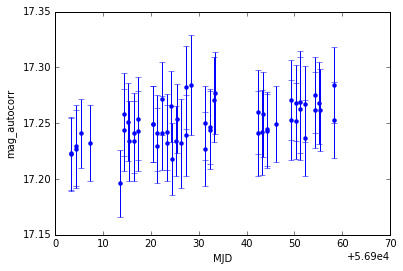

In [87]:
# plot an example lightcurve...
x    = lcs_qso[test_obj_rows]['obsmjd']
y    = lcs_qso[test_obj_rows]['mag_autocorr']
yerr = lcs_qso[test_obj_rows]['magerr_auto']

# Just for plotting:  remove the points that have way too high photometric error... 
mask_outliers = yerr < 2*np.mean(yerr)

x_sel = x[mask_outliers]
y_sel = y[mask_outliers]
yerr_sel = yerr[mask_outliers]

plt.scatter(x_sel,y_sel,lw=0)
plt.errorbar(x_sel,y_sel,yerr_sel, fmt='None')
#plt.ylim(14,23)
plt.ylabel('mag_autocorr')
plt.xlabel('MJD')


In [ ]:
# Save in a CRTS-readable format, so that I can run these through the same analysis as CRTS data... 

# Or just do all day-averaging  on the IPAC table :  
# much quicker solution, since I don't really need the raw data for anything.... 

# Next steps:  modify  
# A_Fig_1_QSO_CRTS_day_averaged_stats.ipynb
# B_sf_CRTS_SDSS_matching_NEW.py

# and perhaps 

# C_sf_load_single_LC.py 

Querying IRSA for  stars : same steps as above for quasars... 